In [1]:
import numpy as np
import sys
import matplotlib.pylab as plt
import pandas as pd
import open3d as o3d
import scipy
import math
from mpmath import mp
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
r_root = 0.11
dt = 0.025



def impedance_weights(r_root,dt):
    acc = 1e-10 #numerical accuracy of impedance fcn
    N = math.ceil(1/dt)
    eta = acc**(1/(2*N))
    empty_table = {}
    m = np.linspace(0,2*np.pi,(2*N)+1) #actual [0:2N-1] the size of 2N
    zeta = eta * np.exp(1j*m)
    Xi = 0.5*(zeta**2) - (2*zeta) + (3/2)
    [Z_impedance, table] = impedance( Xi/dt, r_root, 0, 0, empty_table)
    print('Progress: Impedance calculated')
    z_n = np.zeros(N+1, dtype = np.complex_)
    weighting = np.concatenate (([1], 2*np.ones(2*N-1),[1]))/ (4 * N) 
    for n in range (0,N+1): # actual range [0,N]
        z_n[n] = ((1/(eta**n))*np.sum(weighting*Z_impedance * np.exp(-1j*n*m)))
    print('Progress: z[n] values calculated')
    z_n = np.real(z_n)
        
    plt.plot(z_n)
    plt.show()

    return z_n
    
def impedance( s, r_root, N_alpha, N_beta, table):
    r_min = 0.0083
    alpha = 0.91
    beta = 0.58
    ZL = np.zeros(np.size(s), dtype = np.complex_)
    r_0 = r_root * (alpha ** N_alpha) *(beta ** N_beta)
    if r_0 < r_min:
        
        ZL[:] = 0
    else:
        try:
            ZD1 = table[N_alpha + 1 , N_beta]
        except:
            [ZD1, table] = impedance( s,r_root,N_alpha+1,N_beta,table)
        try:
            ZD2 = table[N_alpha, N_beta +1,:]
        except:
            [ZD2, table] = impedance( s, r_root, N_alpha, N_beta + 1, table)
            
            
       
        ZL = (ZD1 * ZD2) / (ZD1 + ZD2)#ZL needs to be an array of values over the s_range size
        
    Z0 = singleVesselImpedance(ZL,s,r_0)
    table[N_alpha,N_beta] = Z0
    return [Z0, table]
                     
def singleVesselImpedance(ZL, s_range, r_0):
    gamma = 2 #velocity profile
    mu = 0.048 #blood viscosity
    lambd = 50 #length/radius ratio
    rho = 1.055 #blood density
    L = r_0 *lambd
    A0 = np.pi * (r_0 ** 2)
    Ehr = (2e7 *np.exp( -22.5*r_0) + 8.65e5) #Youngs Modulus * vessel thickness/radius
    C = (3/2) *(A0)/(Ehr)#complaince
    delta = (2 * mu*(gamma +2))/ (rho *r_0**2)
    i = 0
    Z0 = np.zeros(np.size(s_range), dtype = np.complex_)
    for s in s_range:
        if s == 0:
            Z0[i] = ZL[i] + (2*(gamma +2)*mu* lambd) / (np.pi * r_0**3)
            print('s=0')
        else:
            d_s = (A0/(C*rho*s*(s+delta)))**(0.5)
            num = ZL[i] +np.tanh(L/d_s)/(s*d_s*C)
            denom = s*d_s*C*ZL[i]*np.tanh(L/d_s) + 1
            Z0[i] = num/denom
        i = i + 1
    return Z0

Progress: Impedance calculated
Progress: z[n] values calculated


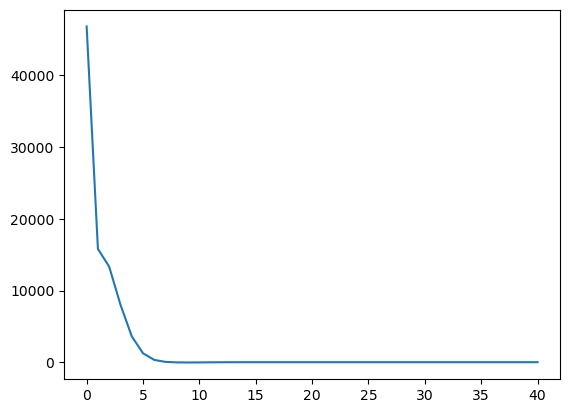

[ 4.68264116e+04  1.58016600e+04  1.33258452e+04  8.02098824e+03
  3.61756374e+03  1.24247477e+03  3.18975776e+02  4.31377288e+01
 -2.69472021e+01 -3.85007330e+01 -2.97580787e+01 -1.67356457e+01
 -7.46698110e+00 -2.88241505e+00 -1.00679629e+00 -2.62522396e-01
  1.35574988e-02  7.53460301e-02  5.89147741e-02  3.28454821e-02
  1.60777372e-02  7.25318851e-03  2.80051703e-03  7.69979625e-04
  4.70499799e-05 -1.11488929e-04 -1.01785001e-04 -6.61051173e-05
 -3.64162297e-05 -1.70174984e-05 -6.74198308e-06 -2.06909277e-06
 -4.07851530e-07 -2.10729330e-07 -3.92709325e-07  4.85269160e-08
  1.10099738e-06  1.22490129e-06 -8.53476273e-07 -2.13132753e-07
  2.10320650e-07]


In [4]:
zn = impedance_weights(r_root, dt)
print(zn)